# ADA Assignment 3

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [2]:
# for file handling
import os, sys

# for data manipulation
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for text processing
import re

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


# supress warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data Loading

In [3]:
data_dir_path = os.path.join('data', 'raw', 'archive')

# read the data
df1 = pd.read_csv(os.path.join(data_dir_path, 'completeSpamAssassin.csv'))
df2 = pd.read_csv(os.path.join(data_dir_path, 'enronSpamSubset.csv'))
df3 = pd.read_csv(os.path.join(data_dir_path, 'lingSpam.csv'))

In [4]:
df1.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
df2.head()

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [6]:
df3.head()

,Unnamed: 0,Body,Label
0,0,Subject: great part-time or summer job !\n \n ...,1
1,1,Subject: auto insurance rates too high ?\n \n ...,1
2,2,Subject: do want the best and economical hunti...,1
3,3,Subject: email 57 million people for $ 99\n \n...,1
4,4,Subject: do n't miss these !\n \n attention ! ...,1


# 2. Data Preprocessing

## 2.1 Data Cleaning

### `df1`

In [7]:
df1.columns

Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')

In [8]:
# drop useless columns
df1.drop('Unnamed: 0', axis=1, inplace=True)

# rename the columns
df1.rename(columns={'Body': 'text', 'Label': 'label'}, inplace=True)

In [9]:
# print the shape of the dataframe
print(df1.shape)

(6046, 2)


In [10]:
df1.head()

,text,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [11]:
# check for null values
df1.isnull().sum()

text     1
label    0
dtype: int64

In [12]:
# drop the null rows
df1.dropna(inplace=True)

There are multiple rows containing the value `'empty'` in the `text` column. We will remove these rows.

In [13]:
# check for rows containing 'empty' string in the `text` column and get the count
df1[df1['text'] == 'empty'].count()

text     533
label    533
dtype: int64

In [14]:
# drop the rows containing 'empty' string in the `text` column
df1 = df1[df1['text'] != 'empty']

In [15]:
# print the shape of the dataframe
print(df1.shape)

(5512, 2)


### `df2`

In [16]:
df2.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Body', 'Label'], dtype='object')

In [17]:
# drop useless columns
df2.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

# rename the columns
df2.rename(columns={'Body': 'text', 'Label': 'label'}, inplace=True)

In [18]:
# print the shape of the dataframe
print(df2.shape)

(10000, 2)


In [19]:
df2.head()

,text,label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [20]:
# check for null values
df2.isnull().sum()

text     0
label    0
dtype: int64

### `df3`

In [21]:
df3.columns

Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')

In [22]:
# drop useless columns
df3.drop('Unnamed: 0', axis=1, inplace=True)

# rename the columns
df3.rename(columns={'Body': 'text', 'Label': 'label'}, inplace=True)

In [23]:
# print the shape of the dataframe
print(df3.shape)

(2605, 2)


In [24]:
df3.head()

,text,label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


In [25]:
# check for null values
df3.isnull().sum()

text     0
label    0
dtype: int64

## 2.2 Combining Data

All the three dataframes have 2 columns named `text` and `label`. We will combine them into a single dataframe.

In [26]:
# combining the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# print the shape of the dataframe
print(df.shape)

(18117, 2)


In [27]:
df.head()

,text,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


## 2.3 Text Preprocessing

In [28]:
# some helper functions to clean the text

# function to remove the string 'Subject:' from the text
def remove_subject(text):
    text = re.sub(r'Subject:', '', text)
    return text

# function to remove contractions
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    return text

def text_process(text):
    # convert to lowercase
    text = text.lower()

    # replace all urls with the string 'links'
    text = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'links', text)
    
    # replace numbers with the string 'number'
    text = re.sub(r'\d+(\.\d+)?', 'number', text)

    # replace '\n' with a space
    text = re.sub(r'\n', ' ', text)

    # replace large white spaces with a space
    text = re.sub(r'\s+', ' ', text)

    # replace all email ids with the string 'mailid'
    # text = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'mailid', text)

    # replace all money symbols with the string 'moneysymb'
    text = re.sub(r'£|\$', 'moneysymb', text)

    # replace all phone numbers with the string 'phonenumber'
    text = re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumber', text)

    # replace all special characters with a space
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)

    return text

# function to extract length of the text
def text_len(text):
    # tokenize the text
    tokens = text.split()
    return len(tokens)

In [29]:
%%time

# preprocess the text
df['text'] = df['text'].apply(remove_subject)
df['text'] = df['text'].apply(decontracted)
df['text'] = df['text'].apply(text_process)

df.head()

CPU times: user 4.56 s, sys: 161 ms, total: 4.72 s
Wall time: 4.72 s


,text,label
0,save up to number on life insurance why spend...,1
1,number fight the risk of cancer http www adcli...,1
2,number fight the risk of cancer http www adcli...,1
3,adult club offers free membership instant acc...,1
4,i thought you might like these number slim dow...,1


In [30]:
# add an extra column to the dataframe to store the length of the text
df['text_length'] = df['text'].apply(text_len)

df.head()

,text,label,text_length
0,save up to number on life insurance why spend...,1,175
1,number fight the risk of cancer http www adcli...,1,140
2,number fight the risk of cancer http www adcli...,1,118
3,adult club offers free membership instant acc...,1,427
4,i thought you might like these number slim dow...,1,113


In [31]:
# separate the features and target variables
X = df['text']
y = df['label']

## 2.4 EDA

In [32]:
# print the shapes
print(X.shape)
print(y.shape)

(18117,)
(18117,)


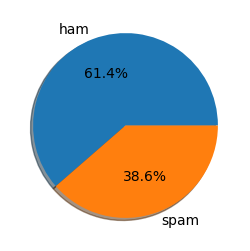

In [33]:
# plot a pie chart to visualize the distribution of the target variable
plt.figure(figsize=(3, 3))
plt.pie(y.value_counts(), labels=['ham', 'spam'], autopct='%1.1f%%', shadow=True)
plt.show()

## 2.5 Data Splitting

In [34]:
# stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Logistic Regression

In [35]:
# tfidf vectorizer
tfidf = TfidfVectorizer()

# logistic regression model
lr = LogisticRegression(solver='lbfgs')

model = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', lr)
])

# fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

## 3.1 Evaluation

In [36]:
y_pred = model.predict(X_test)

# print the confusion matrix
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')

Confusion Matrix:
[[2195   30]
 [  53 1346]]


In [37]:
# print classification report

print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2225
           1       0.98      0.96      0.97      1399

    accuracy                           0.98      3624
   macro avg       0.98      0.97      0.98      3624
weighted avg       0.98      0.98      0.98      3624



In [38]:
# print the accuracy score
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

# print the weighted precision score
print(f'Weighted Precision Score: {precision_score(y_test, y_pred, average="weighted")}')

# print the weighted recall score
print(f'Weighted Recall Score: {recall_score(y_test, y_pred, average="weighted")}')

# print the weighted f1 score
print(f'Weighted F1 Score: {f1_score(y_test, y_pred, average="weighted")}')

Accuracy Score: 0.9770971302428256
Weighted Precision Score: 0.9771083902588589
Weighted Recall Score: 0.9770971302428256
Weighted F1 Score: 0.9770611003024023


This model reports the following metrics:
- **Accuracy:** 97.70
- **Precision:** 97.71
- **Recall:** 97.70
- **F1 Score:** 97.70

## 3.2 Testing on real-world examples

In [39]:
# extract some spam texts from X_test
spam_texts = X_test[y_test == 1].values[:2]

# extract some ham texts from X_test
ham_texts = X_test[y_test == 0].values[:2]

# print the spam texts
print('Spam Texts:')
for text in spam_texts:
    print(text[:200])
    print()

# print the ham texts
print('Ham Texts:')
for text in ham_texts:
    print(text[:200])
    print()

Spam Texts:
 unreal gains by this pic of stockckck yap internationa inc ypil voip technoiogy requires no computer or high speed internet connection for its dia up product current price moneysymb number watch this

 a man endowed with a number number hammer is simply better equipped than a man with a number number hammer would you rather havemore than enough to get the job done or fall short it is totally upto y

Ham Texts:
ok in a galeon browser window i open a new window by middle clicking a link the window comes up under my mouse however keys i type go to the first window anyone else have this problem and did they sol

better late than never i received a grant from project athena mit is original courseware effort and found at the end that they had not thought much about distribution of the courseware instead they ha



In [40]:
spam_result = model.predict(spam_texts)
ham_result = model.predict(ham_texts)

# 1 means spam and 0 means ham
print(f'Spam Result: {spam_result}')
print(f'Ham Result: {ham_result}')

Spam Result: [1 1]
Ham Result: [0 0]
